# Advection

Here we investigate the hyperbolic PDE related to Laplace's equation. 

$$
\frac{1}{c^2} \frac{\partial^2 }{\partial t^2} u(\vec{r},t) - \nabla^2 u(\vec{r},t) = R(\vec{r}, t)
$$

where $c$ is the speed of the wave, $u$ is the field for the wave, and $R$ is a source term. 

In this case, we will investigate linear solutions where the Laplace equation can be broken up into a left-moving wave and a right-moving wave because

$$
\frac{\partial^2}{\partial t^2} - c^2 \frac{\partial^2}{\partial x^2} = \left(\frac{\partial}{\partial t} + c \frac{\partial}{\partial x} \right) \left(\frac{\partial}{\partial t} - c \frac{\partial}{\partial x} \right)
$$

We will investigate three solutions:

- Forward time centered step (FTCS)
$$
u_j^{n+1} = u_j^n - \frac{c\delta t}{2\delta x}\left(u_{j+1}^n - u_{j-1}^N\right)
$$
- Lax
$$
u_j^{n+1} = \frac{1}{2}\left(u_{j+1}^n + u_{j-1}^n \right) - \frac{c\delta t}{2\delta x}\left(u_{j+1}^n - u_{j-1}^N\right)
$$
- Lax/Wendroff
$$
u_j^{n+1} = u_j^n - \frac{c\delta t}{2\delta x}\left(u_{j+1}^n - u_{j-1}^N\right) + \frac{c^2\delta t^2}{2 \delta x^2}\left(u_{j+1}^n + u_{j-1}^n - 2 u_j^n\right)
$$

In [1]:
import math
import time
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:

class Advection : 


    def __init__(self, method="FTCS()", N=500, L=5.0, c=1.0, step_wave=False ):


        self.L = float(L)           # system size
        self.N = 500                # number of cells in x
        self.dx = float(L) / float(N)  # grid spacing
        self.c = 1.0                # wave speed
        self.t = 0.0                # time
        self.dt = self.dx / self.c  # time step
        self.step_number = 0        # integration step number
        self.method = method        # integration algorithm function
        self.x = []                 # grid points
        self.u = []                 # wave amplitude
        self.u_new = []             # amplitude at next step

        self.step_wave = step_wave  # True: step waveform  False: Gaussian cosine
        self.dx = L / float(N)
        self.x = np.arange(N+1)*self.dx
        self.u = self.f_0(self.x)
        self.u_new = np.array(self.u)


    def f_0(self, x):           # initial waveform
        self.x_0 = self.L / 2.0           # position
        self.sigma = 0.1 * self.L         # width
        
        if self.step_wave:
            return np.where( np.abs(x - self.x_0) < self.sigma, 1.0, 0.0 )
        else:                   # Gaussian modulated cosine waveform
            k = np.pi / self.sigma
            gaussian = np.exp(-(x - self.x_0)**2 / (2 * self.sigma**2))
            return np.cos(k * (x - self.x_0)) * gaussian


    def FTCS(self):
        self.u_new[:] = self.u[:] - self.c * self.dt / (2*self.dx) * ( np.roll(self.u,1) - np.roll( self.u,-1) )

    def Lax(self):
        self.u_new[:] = ( np.roll(self.u,1) + np.roll( self.u,-1) ) / 2.0
        self.u_new[:] -= self.c * self.dt / (2*self.dx) * ( np.roll(self.u,1) - np.roll( self.u,-1) )
        
    def Lax_Wendroff(self):
        D = (self.c * self.dt / self.dx)**2 / 2.0
        self.u_new[:] = self.u[:] - self.c * self.dt / (2*self.dx) * ( np.roll(self.u,1) - np.roll( self.u,-1) )
        self.u_new[:] += D * (np.roll(self.u,1)+ np.roll( self.u,-1) - 2 * self.u[:])

    def take_step(self):
        eval('self.' + self.method )
        swap = self.u
        self.u[:] = self.u_new[:]
        self.u_new[:] = swap[:]
        self.t += self.dt
        self.step_number += 1

In [3]:

class Animator :
    def __init__(self, periodic=True,advection=None):
        self.avg_times = []
        self.advection = advection
        self.t = 0.        
        self.fig, self.ax = plt.subplots()
        self.ax.set_ylim(-2.,2.)
        initvals = np.array(self.advection.u)
        self.line, = self.ax.plot(initvals)
        

    def update(self, data) :
        self.line.set_ydata(data)
        return self.line,
        
    def time_step(self):
        self.advection.take_step()
        yield self.advection.u

    def animate(self) :
        self.ani = animation.FuncAnimation( self.fig,        # Animate our figure
                                            self.update,     # Update function draws our data
                                            self.time_step,  # "frames" function does the time step, each iteration
                                            interval=100,     # 50 ms between iterations
                                            blit=False       # don't blit anything
                                            )



<IPython.core.display.Javascript object>


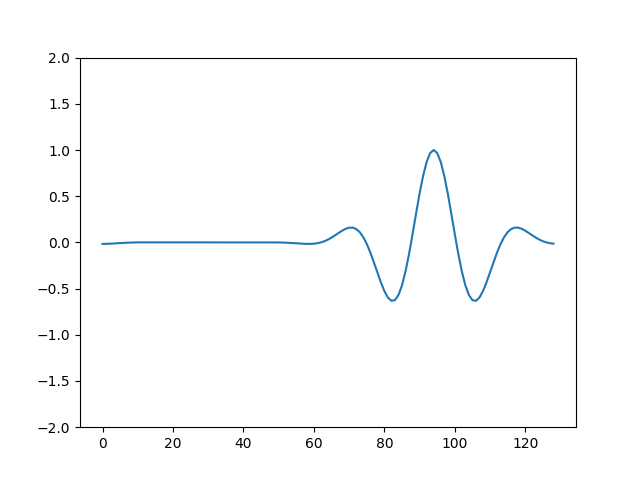

In [4]:
%matplotlib notebook
#method = "FTCS()"
#method = "Lax()"
method = "Lax_Wendroff()"

N = 128
L = 10.0
c = 1.0

advection = Advection( method=method, N=N, L=L, c=c )
animator = Animator(advection=advection)
animator.animate()

